In [1]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("../Mu-Helper/muhelper")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)



<module 'helper_visa' from '/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../Mu-Helper/muhelper/helper_visa.py'>

In [2]:
filepath = "../Keysight/data_waveform/"
filenames= ["waveform_scintillator_bar_sipm_direct.joblib"]

In [43]:
# plot(np.mean(np.array(data_save[1])[inds_keep],axis=0));
# plot(np.array(data_save[1])[inds_keep][6]);


In [3]:
i=0
data_save=joblib.load(filepath+f"{filenames[i]}")
time_series = data_save["metadata"]["time_series"]*1e9

pulses_raw = np.array(data_save[1])

# inds_keep,cut_passage_fraction = hp.cut_pulses(pulses_raw, cut_iterations = 1, cut_amp=[0.003,0.007], cut_triggerpoint = False)
trace_info = hp.get_pulses_info(pulses_raw, pre_trig=800, threshold_in_sigma=5, gaussian_filter_sigma=3)

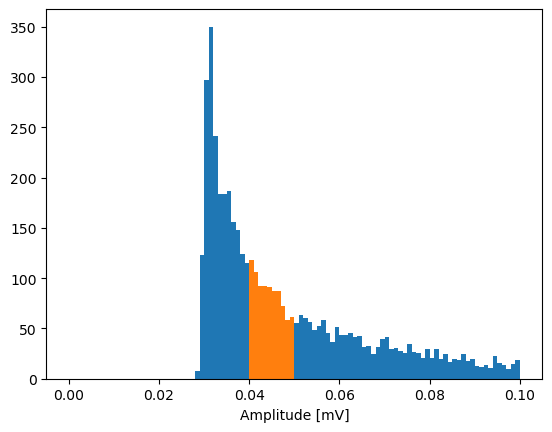

[ 4.25764071e-01  4.26660629e-01  7.14901326e+00  2.75999409e+02
  3.02776585e-01 -9.85809777e-02  8.70065590e-01]


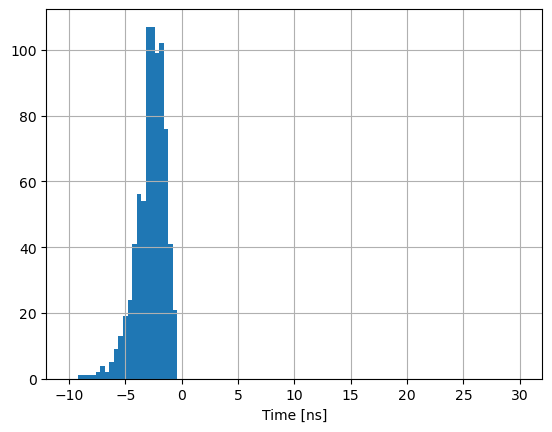

In [109]:
# Select >10 pe events
trace_amp = trace_info[:,-1]
mask_amp = (0.04<trace_amp)&(trace_amp<0.05)
hist(trace_amp,bins=100, range=(0,0.005*20));
hist(trace_amp[mask_amp],bins=100, range=(0,0.005*20));
xlabel("Amplitude [mV]")
show()

#------------------------------------------
# Find trigger time at 1.5 pe
trigger_threshold = 0.0045*0.5
trigger_time_ind = np.array([np.argmax(i>trigger_threshold) for  i in pulses_raw])
# trigger_time_ind = np.copy(trace_info[:,-2])
trigger_time = time_series[trigger_time_ind]
# trigger_time_selected_1pe = trigger_time[mask_amp&mask_pileup]
# passage_fraction = sum(mask_amp&mask_pileup)/len(mask_amp)
# print("passage_fraction",passage_fraction)


n,ibins,_ = hist(trigger_time[mask_amp],bins=100,range=(-10,30));
bincenters= 0.5*(ibins[1:]+ibins[:-1])

x=bincenters
y=n
# popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y),x[np.argmax(y)],2,10], maxfev=1000, makeplot=True)
# exp = lambda x, A,tau: A*np.exp(-x/tau)
# popt, pcov, info, f = hp.fit_curve(exp,x,y, p0=[np.max(y),10], fit_range=(3,30),maxfev=1000, makeplot=True)

# yscale("log")
# xlim(-5,45)
ylim(-0.0002,)
grid(which="both")
xlabel("Time [ns]")
print(popt)

[ 4.25764071e-01  4.26660629e-01  7.14901326e+00  2.75999409e+02
  3.02776585e-01 -9.85809777e-02  8.70065590e-01]


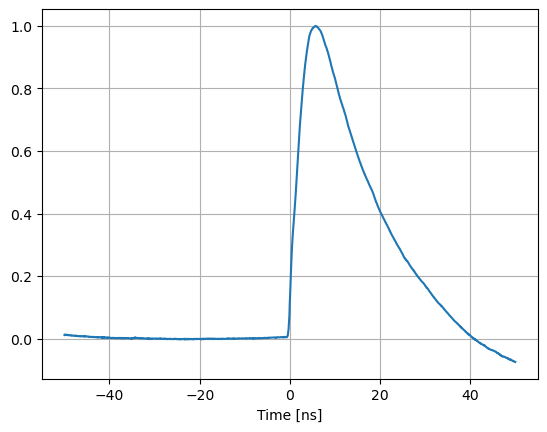

['data/averaged_pulse_scintillator_direct.joblib']

In [111]:
#-----------------------------------------------------------------------------------------
# Make average pulse
mask = mask_amp
pulse_avg = np.zeros_like(pulses_raw[0])
for i in np.flatnonzero(mask):
    time_offset = trigger_time_ind[i]-len(pulses_raw[0])//2
    pulse = np.roll(pulses_raw[i], -int(time_offset))
    pulse/=max(pulse)
    pulse_avg +=pulse
    # print(time_offset)
    # pulse_avg +=pulses_raw[i]
pulse_avg-=np.mean(pulse_avg[:int(len(pulse_avg)/2.2)])

mask_save = abs(time_series)<50
pulse_avg = pulse_avg[mask_save]
pulse_avg/=max(pulse_avg)
pulse_avg_time = time_series[mask_save]

# PLot and fit
plot(pulse_avg_time, pulse_avg)
x=time_series
# y=pulse_avg
# popt, pcov, info, f = hp.fit_curve(hp.Pulse2,x,y, p0=[0.5,5,20,np.max(y),np.max(y)/2,x[np.argmax(y)],np.max(y)], maxfev=1000, makeplot=True)

# yscale("log")
# xlim(-10,45)
# ylim(-0.0002,)
grid(which="both")
xlabel("Time [ns]")
print(popt)
show()


pulse_save = {"time_series_ns":pulse_avg_time,
              "averaged_pulse":pulse_avg}
# joblib.dump(pulse_save,"data/averaged_pulse_scintillator_direct.joblib")

dict_keys(['time_series_ns', 'averaged_pulse'])
dict_keys(['time_series_ns', 'averaged_pulse_1pe_volt'])
[ 0.97107333 -0.15806275  3.45027289 11.65690897]


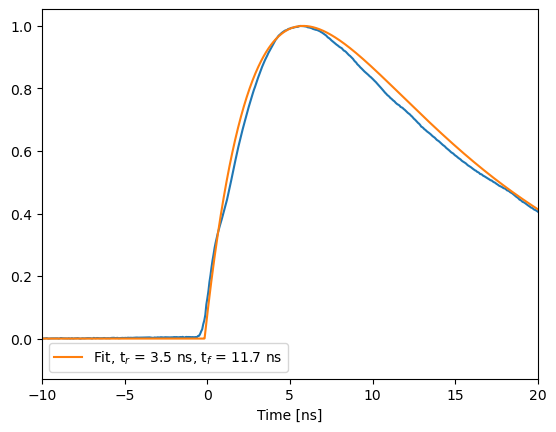

Scintillator parameter [A, x0, t1, t2] [ 0.97107333 -0.15806275  3.45027289 11.65690897]
[ 3.70182879e-01  3.72998472e-01  6.81495922e+00  5.04106238e-01
  1.90717859e-03 -6.16528773e-02  9.06642633e-01]


/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../Mu-Helper/muhelper/helper_basic.py:56: RuntimeWarning: overflow encountered in exp
  pulse = (A1     *     (np.exp(-times[mask] / tau_f1))
/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../Mu-Helper/muhelper/helper_basic.py:61: RuntimeWarning: invalid value encountered in true_divide
  pulse/=max(pulse)


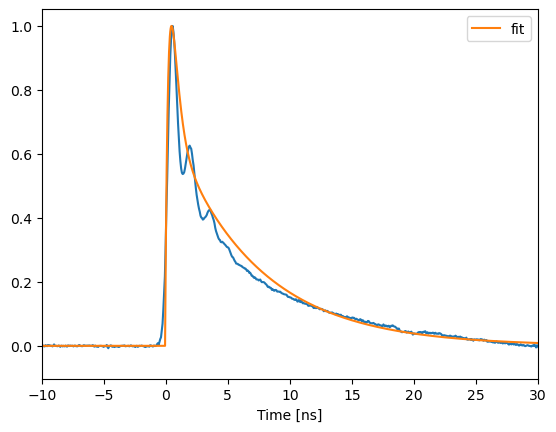

Sipm pulse parameter [tr, tf1, tf2, A1, A2, t0, A0] [ 3.70182879e-01  3.72998472e-01  6.81495922e+00  5.04106238e-01
  1.90717859e-03 -6.16528773e-02  9.06642633e-01]
0.3701828786408546,0.3729984716593019,6.814959222551109,0.5041062382952181,0.0019071785944415564,-0.061652877266861195,0.9066426326071314


In [134]:
data1 = joblib.load("data/averaged_pulse_scintillator_direct.joblib")
print(data1.keys())
scint_time = data1["time_series_ns"]
scint_pulse = data1["averaged_pulse"]
scint_pulse/=max(sipm_pulse)




data2 = joblib.load("../Keysight/data_waveform/averaged_pulse_1pe_preamp_v4_40.7V.joblib")
print(data2.keys())
sipm_time = data2["time_series_ns"]
sipm_pulse = data2["averaged_pulse_1pe_volt"]
sipm_pulse/=max(sipm_pulse)


# Fit the sipm pulse 
plot(scint_time,scint_pulse)
x=scint_time
y=scint_pulse
# popt, pcov, info, f = hp.fit_curve(hp.Pulse2,x,y, p0=[2,3,7,np.max(y)*0.3,np.max(y)*0.8,x[np.argmax(y)],np.max(y)], fit_range=(-20,30), maxfev=1000, makeplot=False)
popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y),x[np.argmax(y)],2,10], fit_range=(-20,30), maxfev=1000, makeplot=False)
fit_plotx = np.linspace(min(x),max(x),4000)
fit_ploty = hp.Pulse(fit_plotx, *popt)
fit_ploty/=max(fit_ploty)
print(popt)
plot(fit_plotx, fit_ploty, label=f"Fit, t$_r$ = {popt[2]:.1f} ns, t$_f$ = {popt[3]:.1f} ns")
xlim(-10,20)
legend()
xlabel("Time [ns]")
show()
print("Scintillator parameter [A, x0, t1, t2]", popt)


# Fit the sipm pulse 
plot(sipm_time,sipm_pulse)
x=sipm_time
y=sipm_pulse
popt, pcov, info, f = hp.fit_curve(hp.Pulse2,x,y, p0=[0.3,3,20,np.max(y)*0.5,np.max(y)*0.1,x[np.argmax(y)],np.max(y)], maxfev=1000, makeplot=False)
# popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y),x[np.argmax(y)],2,10], maxfev=1000, makeplot=True)
fit_plotx = np.linspace(min(x),max(x),4000)
fit_ploty = hp.Pulse2(fit_plotx, *popt)
fit_ploty/=max(fit_ploty)
print(popt)
plot(fit_plotx, fit_ploty, label="fit")
xlim(-10,30)
legend()
xlabel("Time [ns]")
show()
print("Sipm pulse parameter [tr, tf1, tf2, A1, A2, t0, A0]", popt)
print(*popt,sep=",")


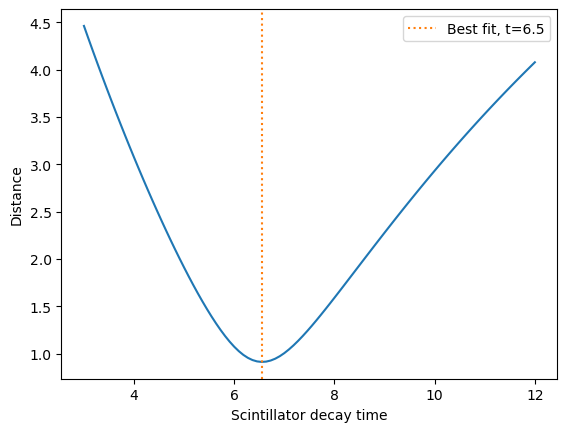

Text(0, 0.5, 'Amplitude')

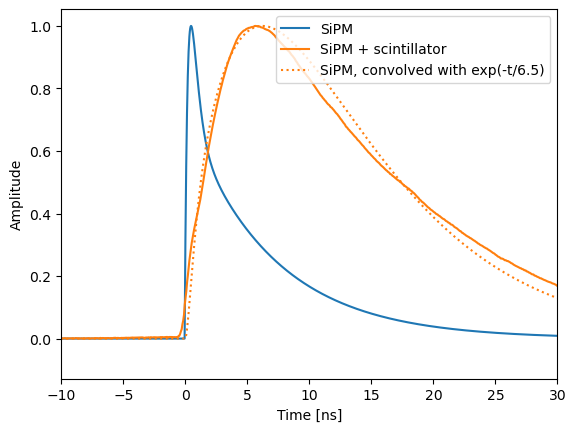

In [145]:



def chi2(t_scint):
    exp_decay = np.exp(-t/t_scint)*np.heaviside(t,0)
    sipm_response = hp.Pulse2(t, 0.3701828786408546,0.3729984716593019,6.814959222551109,0.5041062382952181,0.0019071785944415564,-0.061652877266861195,0.9066426326071314)
    y_smeared = np.convolve(exp_decay, sipm_response, mode="same")
    y_smeared/=max(y_smeared)   
    mask =  (scint_time>-10)&(scint_time<30)
    return np.linalg.norm(scint_pulse[mask] - y_smeared[mask])

tscint_scan = np.linspace(3,12,100)
chi2s = [chi2(i) for i in tscint_scan]
tscint_best = tscint_scan[np.argmin(chi2s)]

plot(tscint_scan, chi2s)
axvline(tscint_best, color="C1", linestyle=":",label=f"Best fit, t={tscint_best:.1f}")
legend()
xlabel("Scintillator decay time")
ylabel("Distance")
show()
    
    
t = scint_time
exp_decay = np.exp(-t/tscint_best)*np.heaviside(t,0)
sipm_response = hp.Pulse2(t, 0.3701828786408546,0.3729984716593019,6.814959222551109,0.5041062382952181,0.0019071785944415564,-0.061652877266861195,0.9066426326071314)
y_smeared = np.convolve(exp_decay, sipm_response, mode="same")
y_smeared/=max(y_smeared)

# exp_decay1 = np.exp(-t/1.8)*np.heaviside(t,0)
# exp_decay2 = np.exp(-t/7)*np.heaviside(t,0)
# y_smeared_exp = np.convolve(exp_decay1, exp_decay2, mode="same")
# y_smeared_exp/=max(y_smeared_exp)


plot(fit_plotx,fit_ploty, label="SiPM")
plot(scint_time,scint_pulse, label="SiPM + scintillator")
plot(scint_time,y_smeared, color="C1", linestyle=":", label=f"SiPM, convolved with exp(-t/{tscint_best:.1f})")
# plot(scint_time,y_smeared_exp)
xlim(-10,30)
legend()
xlabel("Time [ns]")
ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

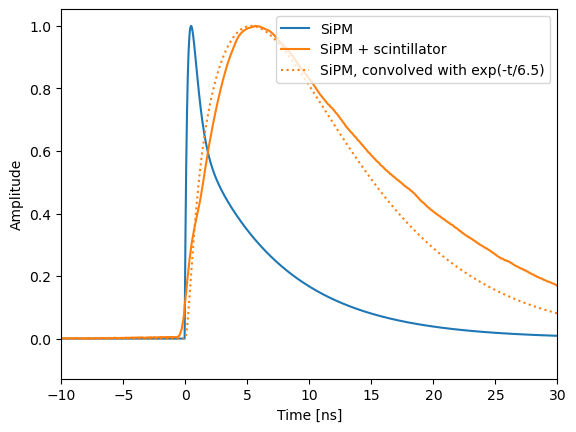

In [156]:
t = scint_time
exp_decay = np.exp(-t/5)*np.heaviside(t,0)
sipm_response = hp.Pulse2(t, 0.3701828786408546,0.3729984716593019,6.814959222551109,0.5041062382952181,0.0019071785944415564,-0.061652877266861195,0.9066426326071314)
y_smeared = np.convolve(exp_decay, sipm_response, mode="same")
y_smeared/=max(y_smeared)

exp_decay1 = np.exp(-t/5)*np.heaviside(t,0)
exp_decay2 = np.exp(-t/8)*np.heaviside(t,0)
y_smeared_exp = np.convolve(exp_decay1, exp_decay2, mode="same")
y_smeared_exp/=max(y_smeared_exp)


plot(fit_plotx,fit_ploty, label="SiPM")
plot(scint_time,scint_pulse, label="SiPM + scintillator")
plot(scint_time,y_smeared, color="C1", linestyle=":", label=f"SiPM, convolved with exp(-t/{tscint_best:.1f})")
# plot(scint_time,y_smeared_exp)
xlim(-10,30)
legend()
xlabel("Time [ns]")
ylabel("Amplitude")